In [56]:
using Revise

In [2]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`


In [3]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM,DelimitedFiles

In [173]:
using SuSiEGLMM

In [105]:
?glmmSusie

search: glmmSusie



```
 glmmSusie(y::Vector{Float64},X::Matrix{Float64},X₀::Union{Matrix{Float64},Vector{Float64}},T::Matrix{Float64},
      S::Vector{Float64};tol=1e-4,τ²::Float64 = 1.99,L::Int64=10,Π::Vector{Float64}=ones(size(X,2))/size(X,2),σ0::Vector{Float64} = ones(L))


 Fit a logistic mixed model for SUSIE (sum of single effects).  Returns a type of `Result`, struct of arrays.
```


In [106]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

#empirical grm
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

  1.095364 seconds (18.08 M allocations: 513.283 MiB, 6.31% gc time, 10.40% compilation time)


In [107]:
Seed(24)

In [108]:
T,S = svdK(K0;LOCO=false) 

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787193 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479863 … 0.001685475850207202 -0.02001944231048721; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

In [109]:
size(X)

(503, 4000)

In [110]:
X1= (X.-mean(X,dims=1))./std(X,dims=1)
n,p = size(X1)

L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 


In [11]:
# data preparation
    τ2= 1.5  # true τ²

#for j = 1:B
    b_true[1]= randn(1)[1] 

    g=rand(MvNormal(τ2*K0)) #grm
    p= logistic.(X1*b_true+g) 
    #generating binary outcome
    Y=convert(Vector{Float64} ,rand.(Bernoulli.(p))) ;  
    X₀=ones(n,1); #covariates(intercepts)

In [12]:
b_true[1] # true b

0.12169754246032718

In [38]:
 # transforming data         
     Xt, Xt₀, y1 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
#      y1= SuSiEGLMM.rotateY(Y1,T)

#initial values
#     τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

([0.6203341866904861 1.2821380992099884 … 1.043867526136292 -0.1389906140735533; -0.6509038299601514 -1.2818875721823844 … -1.4765123447412196 0.9787359714523717; … ; 0.3973684522059859 -0.6252119514266032 … 0.2937676417753836 -0.4056734188047211; 2.498001805406602e-16 -1.3877787807814457e-15 … -1.3877787807814457e-15 -3.7192471324942744e-15], [8.104628079763643e-15; -1.7763568394002505e-15; … ; 5.176414852314792e-15; -22.427661492005853;;], [0.7380182007198995, 0.4932809620366664, -0.20932647335519852, 0.23574420649902875, -0.3390369393086783, -0.3800707480870755, 0.4493067890313288, -0.07527503784950619, 1.0065495959264241, 0.34437937462374313  …  -0.5050540161006902, 0.04812784483224336, 0.6473613710563536, -0.19269570999865615, -0.06470431183997619, 0.7611326098578076, -0.03169940760200806, -0.14082160584554093, -0.07353240261188163, 0.6911108412049504])

In [13]:
#debugging
@time res= glmmSusie(Y,X1,X₀,T,S;tol=tol,τ²= 2.5,L=L)


603
 27.252065 seconds (15.07 M allocations: 34.603 GiB, 11.85% gc time, 16.14% compilation time)


Result([0.6524901182755911, 0.6184070968466127, 0.5943665763273984, 0.59448456203368, 0.5994032482415731, 0.6004846477838822, 0.6042359291378836, 0.5823473445565246, 0.6744000444794052, 0.5916156772494535  …  0.30955338895943496, 0.3053677182659665, 0.309713935703812, 0.3031921977927418, 0.3022731558892352, 0.3085713469350707, 0.29870644878756264, 0.2978323051344029, 0.2943472226636677, 387.11614412912763], [-17.22842782143601], [0.00011555910625579783], 0.21061676102332783, -659.5636349583392, [0.00026010953356224697; 0.00025035081029284485; … ; 0.00024955448027751093; 0.0002528484160712172;;], [0.0032477313605729103; -0.001350480971123967; … ; -0.0010475188478008975; 0.0020219294738140635;;], [0.00011404312077513636; 0.00011404517578826095; … ; 0.00011404499816229501; 0.00011404502041071244;;])

In [31]:
logistic(minimum(res.ξ))

0.5730600703457543

In [300]:
X₀

503×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [242]:
τ²=1.99; Π=ones(p)/p;σ0=ones(L);
Σ0= 2(cov(Xt₀)+I) # initial variance of prior β
ξ0=guessξ0(y1,Xt₀,Xt,S,Σ0,τ²,σ0,Π,n,L)

Xy₀=SuSiEGLMM.getXy('T',Xt₀,y1)
Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 

intOut([0.4307742070354993;;], [-35.981727194550245], [0.7380182007199507, 0.4932809620366551, -0.20932647335519286, 0.23574420649905492, -0.3390369393086967, -0.38007074808708086, 0.44930678903129045, -0.07527503784950708, 1.0065495959263921, 0.34437937462373386  …  -0.5050540161006711, 0.04812784483220738, 0.6473613710564481, -0.19269570999859847, -0.06470431183994825, 0.7611326098578247, -0.031699407602064515, -0.14082160584559789, -0.0735324026118394, 0.401086479829557], [0.17561276958721417, 0.17624690280351132, 0.17686404107337775, 0.17705289578756672, 0.1772204811097033, 0.1775268778410138, 0.17783076804123119, 0.1782866724091776, 0.1783054751785328, 0.1785844113702009  …  0.22506367991207377, 0.2251500584550706, 0.225363119768363, 0.22553800695881884, 0.22561818879569284, 0.22581374737654525, 0.22611998026381633, 0.2262800597987398, 0.22675300657374733, 0.0003593920617007933], [1.4232761835615985e-15 -3.1307739121812847e-16 … 1.1737676310353795e-15 -0.008060323502739473], [2.67

In [289]:
Badj.β̂

1-element Vector{Float64}:
 -23.640100541443648

In [277]:
#  ghat =zeros(n); Vg = zeros(n);
#     ghat2=zeros(n); τ2_new=zeros(1); τ2 =[τ²]; 
    
#     βhat=zeros(c)
#     A0 =repeat(Π,outer=(1,L)) ; 
#     B0=zeros(p,L); AB2=zeros(p,L)
   
#     A1 =copy(A0); B1=zeros(p,L); Sig1=zeros(p,L)
#     σ0_new = zeros(L); ξ_new = zeros(n);

#  el0=0.0;
# Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 
# postG!(ghat,Vg,Badj,Xt,S,τ2,A0,B0)
# emG!(ghat2,τ2_new,Vg,ghat,S)

postB!(A1, B1, Sig1,Badj,ghat,Xt,σ0,A0,B0,Π,L)
σ0_new, AB2 = emB(A1, B1, Sig1,L)
mStep!(ξ_new,A1,B1,Sig1,ghat,Vg,Badj,Xt,Xt₀,n)
el1=ELBO(ξ_new,σ0_new,τ2_new,Badj,A1,B1,AB2,Sig1,Π,ghat,ghat2,Vg,S,Xt,Xy₀,Σ0,L,n)

# crit=abs(el1-el0)
# ξ0[:]=ξ_new; τ2[:]=τ2_new;el0=el1;σ0[:]=σ0_new;βhat[:]=Badj.β̂;
#          A0[:,:]=A1;B0[:,:]=B1
        

-688.3037305907769

In [278]:
[σ0 σ0_new]

1×2 Matrix{Float64}:
 0.0116125  0.00773446

In [279]:
[ξ0 ξ_new]

503×2 Matrix{Float64}:
   2.18471     2.13398
   1.77679     1.73949
   1.48504     1.4605
   1.50019     1.47505
   1.58349     1.55437
   1.62096     1.59003
   1.69475     1.66074
   1.41481     1.39306
   2.64347     2.58615
   1.57112     1.54229
   1.86755     1.82661
   3.28979     3.23635
   1.48032     1.45544
   ⋮         
   0.874822    0.85898
   1.03308     1.00929
   0.932049    0.91323
   0.854354    0.839341
   0.972162    0.951067
   0.858492    0.843031
   0.847381    0.832447
   1.00356     0.980685
   0.837853    0.823091
   0.840699    0.825659
   0.828403    0.8137
 619.969     530.915

In [275]:
# gs=zeros(n,4)
gs[:,:]=[ghat ghat2 S Vg]
gs

503×4 Matrix{Float64}:
  1.55317       4.52246      1.84986      2.11013
  0.993047      3.00602      1.82617      2.01988
 -0.408181      2.12222      1.80236      1.95561
  0.4586        2.16388      1.79537      1.95357
 -0.663658      2.40312      1.78867      1.96268
 -0.743439      2.51402      1.77723      1.96131
  0.881018      2.74219      1.76599      1.96599
 -0.143756      1.93135      1.749        1.91068
  2.12691       6.64125      1.7485       2.11752
  0.662307      2.36622      1.73815      1.92757
 -1.16037       3.31738      1.73116      1.97091
 -2.86231      10.3999       1.72723      2.2071
 -0.454689      2.10769      1.71896      1.90095
  ⋮                                       
 -0.156691      0.735142     0.459797     0.71059
 -0.551709      1.01347      0.456579     0.709088
 -0.355644      0.83099      0.454373     0.704508
  0.0336485     0.702103     0.452587     0.700971
  0.450798      0.900373     0.448211     0.697155
 -0.133036      0.708328     0.

In [258]:
[ghat ghat2 S Vg]

503×4 Matrix{Float64}:
  1.59677       4.72592     1.84986      2.17624
  1.02103       3.12787     1.82617      2.08537
 -0.418988      2.19075     1.80236      2.0152
  0.469304      2.23398     1.79537      2.01374
 -0.682421      2.48971     1.78867      2.02401
 -0.764698      2.60784     1.77723      2.02308
  0.906089      2.84969     1.76599      2.02869
 -0.148333      1.98951     1.749        1.9675
  2.17879       6.91998     1.7485       2.17283
  0.681169      2.45153     1.73815      1.98754
 -1.19469       3.46088     1.73116      2.03359
 -2.91015      10.7162      1.72723      2.24721
 -0.467309      2.17716     1.71896      1.95878
  ⋮                                      
 -0.161591      0.761613    0.459797     0.735501
 -0.570481      1.05968     0.456579     0.734231
 -0.368159      0.864858    0.454373     0.729317
  0.034719      0.726774    0.452587     0.725568
  0.46611       0.93911     0.448211     0.721851
 -0.137922      0.733956    0.444564     0.714934


In [232]:
 #posterior
#         Vg[:]= 1.0./(Badj.λ+1.0./(τ2[1]*S))
        
#         ghat[:]= SuSiEGLMM.getXy('N',Xt,sum(A0.*B0,dims=2)[:,1])
#         ghat[:]= Badj.Ŷ -lmul!(Diagonal(Badj.λ),ghat)
#         lmul!(Diagonal(Vg),ghat)
#          ghat2[:]= Vg+ghat.^2 
    #m-step for τ²
    τ2_new[:].= mean(ghat2./S)

1-element view(::Vector{Float64}, :) with eltype Float64:
 1.787907725248363

In [276]:
[τ2 τ2_new]

1×2 Matrix{Float64}:
 1.85555  1.78609

## Testing score test 

In [111]:
#fix true values of parameters
τ2=0.5;b_true[1]=randn(1)[1]
println(b_true[1])#true b
# init0=[]; init1=[]
B=200

#  tt=zeros(B);
#Ps=zeros(p,R); 
#  Ts1=zeros(p,B);#Ps1=zeros(p,R);
Y0=zeros(n,B);
Y1=zeros(n,B);


for j = 1:B
#     b_true[1]= randn(1)[1] # true b 
#     b_1s[j] = b_true[1]   
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    p0= logistic.(g)
    p1=logistic.(X1*b_true+g) 
    
    Y0[:,j]=rand.(Bernoulli.(p0)) #H0 data
    Y1[:,j]=rand.(Bernoulli.(p1)) #H1 data
    # similarily :
#     Y[:,j] = collect(Iterators.flatten(rand.(Bernoulli.(p1), 1))) 
    # Y0[:,j]=Y1
end

0.12169754246032718


In [120]:
Mx=[maximum([init0[j].ξ init1[j].ξ];dims=1) for j=1:B] # check max ξ for each replicate

200-element Vector{Matrix{Float64}}:
 [3.4284292342498155 2.819471699704196]
 [13.489377765911394 2.640503408030776]
 [2.819471699704192 4.8850836892275025]
 [209.8960528571761 4.885083689227508]
 [6.88398586002103 565.7155903023825]
 [47.20419301714131 2.4376274432093163]
 [2.8194716997041915 6.883985860021055]
 [298.1825142576825 2.399343709750721]
 [209.89605285717812 2.8194716997041933]
 [123.55477143133304 2.4376274432093132]
 [565.7155903023806 2.437627443209316]
 [2.8194716997041933 4.88508368922753]
 [3.4284292342498257 4.885083689227525]
 ⋮
 [2.437627443209314 2.819471699704192]
 [2.4376274432093146 2.8194716997041933]
 [834.2744758270882 2.8194716997041858]
 [3.4284292342498213 2.3993437097507213]
 [4.88508368922751 565.7155903023821]
 [3.070726738372716 6.883985860020989]
 [3.4284292342498155 2.8194716997041955]
 [2.6405034080307814 1282.406069599408]
 [387.1161441291258 2.516357105094869]
 [3.0707267383727146 209.8960528571761]
 [2.437627443209316 2.516357105094871]
 [565.7

In [171]:
Mx[158]

1×2 Matrix{Float64}:
 655.183  2.6405

In [130]:
Inx=findall(Pv0.<0.05);
Pv0[Inx]
Inx[31] #pick one that is extremely small

158

In [117]:
minimum([V0 V1],dims=1) #minimum variances in  H0, H1 data

1×2 Matrix{Any}:
 24.8793  18.7425

In [134]:
logistic.(maximum([init0[158].ξ init1[158].ξ];dims=1))

1×2 Matrix{Float64}:
 1.0  0.933423

In [119]:
display([Pv0[158] P1[158];S0[158] S1[158];V0[158] V1[158]])

3×2 Matrix{Float64}:
  5.97398e-5   0.00203614
 23.6193      22.2284
 34.6268      51.9195

In [102]:
b_true[1]

0.12169754246032718

In [150]:
# ŷ 
r₀=similar(Y0); r₁=similar(Y1);ŷ0=zeros(n,B);ŷ1=zeros(n,B);ŷ2=zeros(n,B);ŷ3=zeros(n,B);
for j=1:B
   r₀[:,j] =  (2Y0[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init0[j].β)+SuSiEGLMM.getXy('T',T,init0[j].μ)) 
   r₁[:,j] =  (2Y1[:,j].-1.0).*(SuSiEGLMM.getXy('N',X₀,init1[j].β)+SuSiEGLMM.getXy('T',T,init1[j].μ)) 
   ŷ0[:,j] = logistic.(init0[j].ξ).*exp.(0.5*(r₀[:,j]-init0[j].ξ))
   ŷ1[:,j] = logistic.(init1[j].ξ).*exp.(0.5*(r₁[:,j]-init1[j].ξ))   
    # full lower bound
   ŷ2[:,j] = log.(logistic.(init0[j].ξ))+0.5*(r₀[:,j]-init0[j].ξ)-Lambda.(init0[j].ξ).*(r₀[:,j].^2-init0[j].ξ.^2)
   ŷ2[:,j] =  exp.(ŷ2[:,j])
   ŷ3[:,j] =  log.(logistic.(init1[j].ξ))+0.5*(r₁[:,j]-init1[j].ξ)-Lambda.(init1[j].ξ).*(r₁[:,j].^2-init1[j].ξ.^2)
    ŷ3[:,j] = exp.(ŷ3[:,j])   
end

In [187]:
#extreme case
[logistic.(r₀[:,158]) ŷ0[:,158] 1.0./(ŷ0[:,158].*(1.0.-ŷ0[:,158])) ŷ2[:,158] 1.0./(ŷ2[:,158].*(1.0.-ŷ2[:,158]))]

503×5 Matrix{Float64}:
 1.0          1.09408e6    -8.35408e-13  5.06556e-86  1.97412e85
 1.0          1.08535e6    -8.48908e-13  4.46749e-86  2.2384e85
 2.2093e-13   2.30145e-7    4.34509e6    2.85045e-98  3.50822e97
 2.25568e-13  2.32796e-7    4.29561e6    3.34586e-98  2.98877e97
 1.0          1.09845e6    -8.28784e-13  3.00309e-86  3.3299e85
 1.0          1.09629e6    -8.32047e-13  2.70645e-86  3.69488e85
 1.0          1.07352e6    -8.67719e-13  5.49096e-86  1.82118e85
 1.0          1.08332e6    -8.52088e-13  4.23874e-86  2.35919e85
 1.0          1.09514e6    -8.33795e-13  3.22928e-86  3.09667e85
 2.27846e-13  2.33975e-7    4.27397e6    3.86958e-98  2.58426e97
 2.2262e-13   2.31322e-7    4.32297e6    2.66505e-98  3.75228e97
 1.0          1.08931e6    -8.42742e-13  3.18139e-86  3.14328e85
 2.19192e-13  2.29617e-7    4.35508e6    2.01147e-98  4.97148e97
 ⋮                                                    
 1.0          1.10055e6    -8.25627e-13  4.72099e-87  2.1182e86
 2.20315e-13  2

In [186]:
# ordinary one
[logistic.(r₀[:,1]) ŷ0[:,1] 1.0./(ŷ0[:,1].*(1.0.-ŷ0[:,1])) ŷ2[:,1] 1.0./(ŷ2[:,1].*(1.0.-ŷ2[:,1]))]

503×5 Matrix{Float64}:
 0.562134  0.529928  4.01438  0.594951  4.14965
 0.568686  0.540339  4.02621  0.597502  4.15812
 0.493372  0.464127  4.0207   0.523188  4.00862
 0.560445  0.528218  4.01278  0.593284  4.14425
 0.560081  0.530326  4.01477  0.59036   4.13505
 0.5341    0.502429  4.00009  0.56639   4.07179
 0.540694  0.500316  4.0      0.582062  4.11073
 0.568889  0.541593  4.02787  0.596619  4.15516
 0.514017  0.47395   4.01089  0.555105  4.04918
 0.551275  0.522628  4.00821  0.580414  4.10621
 0.488343  0.457364  4.0293   0.519969  4.00639
 0.517479  0.463458  4.02148  0.573334  4.08794
 0.502878  0.474234  4.01065  0.532058  4.01651
 ⋮                                      
 0.556901  0.551113  4.04224  0.562709  4.06393
 0.489755  0.481199  4.00566  0.498361  4.00004
 0.569645  0.565685  4.07024  0.573615  4.08863
 0.5106    0.502242  4.00008  0.519003  4.00579
 0.560041  0.554082  4.04735  0.566021  4.07098
 0.52687   0.519003  4.00579  0.534775  4.01944
 0.547107  0.540614  4.0

In [172]:
maximum([logistic.(r₁[:,158]) ŷ1[:,158] ŷ3[:,158]];dims=1)

1×3 Matrix{Float64}:
 0.550639  0.541826  0.851698

In [174]:
#score test
# B=1
Ts0=[];Pv0=[];S0=[];V0=[]; #init0=[];init1=[]
Ts1=zeros(B);P1=zeros(B);S1=zeros(B);V1=zeros(B);
τ0=2.0
 #ŷ=h(ξ)
for j =1:B
#        est0,Xt₀ = glmmNull(Y0[:,j],X₀,T,S;tol=tol,τ0=τ0)
       T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
        Ts0=[Ts0;T0];Pv0=[Pv0;P0];S0=[S0;s0];V0=[V0;v0]
       
#        est1,Xt₀ = glmmNull(Y1[:,j],X₀,T,S;tol=tol,τ0=τ0)
       Ts1[[j]], P1[[j]], S1[[j]], V1[[j]] = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
#        init0=[init0;est0]; init1=[init1;est1]
end
       

    

In [175]:
α=mean(Pv0.<0.05) # type 1 error estimate

0.185

In [176]:
mean(P1.<α) # power

0.69

In [168]:
ts=[];pv=[];sco=[];sv=[];
 ts1=[];pv1=[];sco1=[];sv1=[];
#full lower bound ŷ =h(ξ)exp(0.5*(x-r))
for j=1:B
    T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)  
    T1, P1, S1, V1 = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
    ts=[ts;T0];pv=[pv;P0];sco=[sco;s0];sv=[sv;v0]
    ts1=[ts1;T1];pv1=[pv1;P1];sco1=[sco1;S1];sv1=[sv1;V1]
end

LoadError: DomainError with -8.747320313091935:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [155]:
 tstat=[];pval=[];score=[];svar=[];
 tstat1=[];pval1=[];score1=[];svar1=[];
#full lower bound ŷ =h(ξ)exp(0.5*(x-r)-Λ(ξ)(x^2-r^2)
for j=1:B
    T0, P0, s0, v0 = testStats(init0[j],Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)  
    T1, P1, S1, V1 = testStats(init1[j],Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
    tstat=[tstat;T0];pval=[pval;P0];score=[score;s0];svar=[svar;v0]
    tstat1=[tstat1;T1];pval1=[pval1;P1];score1=[score1;S1];svar1=[svar1;V1]
end
 

In [156]:
α1=mean(pval.<0.05)

0.375

In [157]:
mean(pval1.<α1)

0.81

In [26]:
using Plots

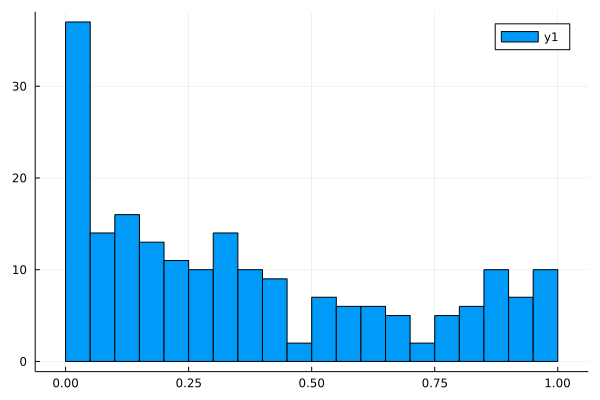

In [180]:
histogram(Pv0,bins=0:0.05:1.0) # ŷ by H0 data using optimal lower bound, h(ξ)

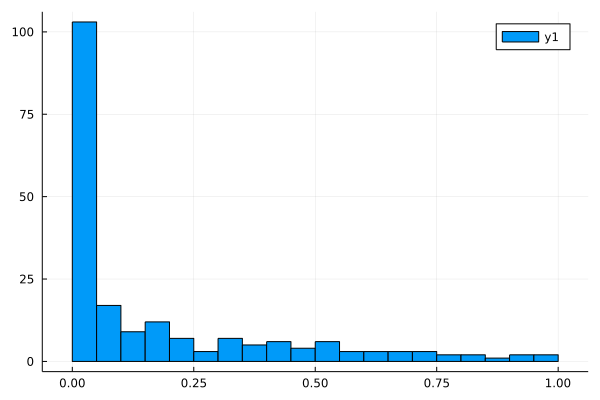

In [181]:
histogram(P1,bins=0:0.05:1.0) # ŷ by H1 data

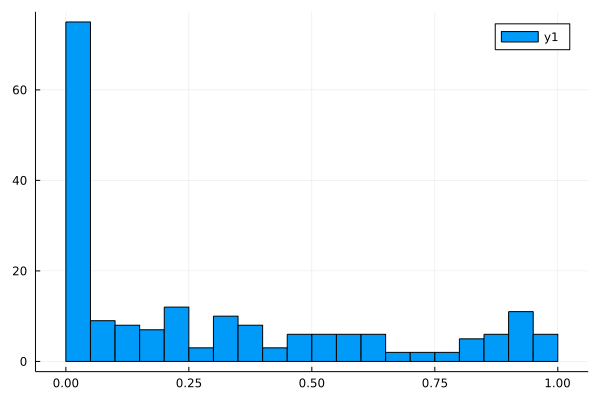

In [182]:
histogram(pval,bins=0:0.05:1.0) #using full lower bound of h(x)

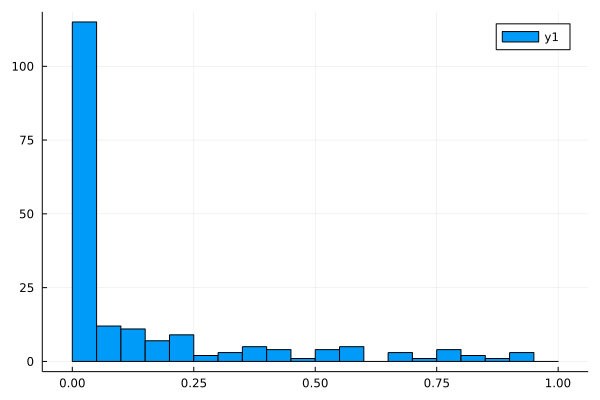

In [183]:
histogram(pval1,bins=0:0.05:1.0)

In [160]:
maximum(pval1)

1.0